# **IEOR E4650  Business Analytics (Fall 2019)**

##**Lecture 10: Weibull Model**

In this lecture, we discuss how to model a timing model.  

Learning objective:

* Understand how to use Weibull model to model timing data
* Understand how the concept of hazard



## Baseline Model

In this lecture, we will discuss a new topic. Previously, the model focused on model the number of occurance. The other commonly used model models the timing of the occurance. This type of model is called timing model.

To illustrate timing model, we study a new dataset related to healthcare management. In this dataset, we track each patient who are released from the hospital. We record after how many days/months a patient will relapse. By the end of the observation period, we might have a patient who has not relapsed. They are recorded as "censored".



In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link="https://drive.google.com/open?id=1uNSppU66HLaLHNM1noTFJ4s_9TQMbJDa"
_,id=link.split("=")
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('myfile.csv')  
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt

import scipy.stats as spst
from scipy.optimize import minimize
import scipy.special as spsp




import warnings
warnings.simplefilter("ignore")

Patients = pd.read_csv('myfile.csv')
Patients.head(10)


,id,age,censor,race,time,time_in_month
0,1,39.0,0,0.0,188,7
1,2,33.0,0,0.0,26,1
2,3,33.0,0,0.0,207,7
3,4,32.0,0,0.0,144,5
4,5,24.0,1,1.0,551,19
5,6,30.0,0,0.0,32,2
6,7,39.0,0,0.0,459,16
7,8,27.0,0,0.0,22,1
8,9,40.0,0,0.0,210,7
9,10,36.0,0,0.0,184,7


##Baseline model

For now, let's not incorporate any covariates. We will focus on the outcome variable, which are

(1) the number of months before a patient relapse.

(2) whether the observation is censored.


Usually, people treat time as a continuous variable. It is important to find a continuous distribution defined on the positive range and has a flexible shape. Weibull distribution is one of the most commonly used distributions.

The pdf of Weibull distribution follows:

$$f(t)=(c\lambda)(t\lambda)^{c-1}e^{-(t\lambda )^c}$$

where $c>0, \lambda>0, t>0$. $E(t)=\frac{\Gamma(1+\frac{1}{c})}{\lambda}$

The cdf of Weibull distribution follows:
$$F(t)=1-e^{-(t\lambda )^c}$$

Exponential distribution is a special case of Weibull distribution when $c=1$.


###Modeling the likelihood

(1) Treating the observed timing as discrete. In this case, the outcome will be considered as "censored", since we are only observing the interger outcomes. What we have is the time that rounded up. $t=1$ means the event happened between $0$ and $1$. Similarly, $t=4$, means the event happened between $3$ and $4$. In this case, instead of using $f(t)$, we should use $F(t)-F(t-1)$ to (1) Treating the observed timing as discrete. In this case, the outcome will be considered as "censored", since we are only observing the interger outcomes. What we have is the time that rounded up. $t=1$ means the event happened between $0$ and $1$. Similarly, $t=4$, means the event happened between $3$ and $4$. In this case, instead of using $f(t)$, we should use $F(t)-F(t-1)$ to model the likelihood.

(2) We also have observations that are censored at $t$. Those people might relapse later, but we just could not follow the long enough. The probability of observing a censored patient is $1-F(t)$. 

In [0]:
y=Patients["time_in_month"].values
censor=Patients["censor"].values
def neg_LL(betas):
  c=np.exp(betas[0])
  lmbda=np.exp(betas[1])
  F_t=1-np.exp(-(y*lmbda)**c)
  F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
  #censored patient
  Ind_Lc=1-F_t
  #uncensored
  #time we observed is round up to the closest integer
  Ind_Lu=F_t-F_t_m1
  Ind_L=Ind_Lc*censor+Ind_Lu*(1-censor)
  return -np.sum(np.log(Ind_L))

guess=-np.random.rand(2)
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

1655.2856250294362
[-0.1713294  -2.25487976]


$$f(t)=(c\lambda)(t\lambda)^{c-1}e^{-(t\lambda )^c}$$

In [0]:



y=Patients["time_in_month"].values
censor=Patients["censor"].values
def neg_LL(betas):
  c=np.exp(betas[0])
  lmbda=np.exp(betas[1])
  F_t=1-np.exp(-(y*lmbda)**c)
  F_t_m1=1-np.exp(-((y-1)*lmbda)**c)
  #censored patient
  Ind_Lc=1-F_t
  #uncensored
  #time we observed is round up to the closest integer
  #if treating time column as continuous
  f_t=(c*lmbda)*(y*lmbda)**(c-1)*np.exp(-(y*lmbda)**c)
  Ind_Lu=f_t
  Ind_L=Ind_Lc*censor+Ind_Lu*(1-censor)
  return -np.sum(np.log(Ind_L))

guess=-np.random.rand(2)
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

1691.006931400067
[ 0.00892228 -2.32972944]


### Model fitting

Here, let's plot the actual v.s. prediction distribution for those patients who relapsed. 



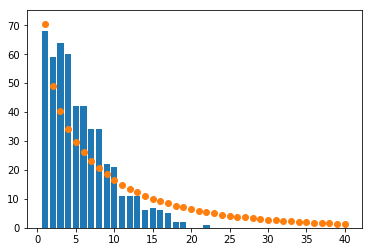

In [0]:
counts=Patients[Patients["censor"]==0].groupby("time_in_month").count()
y1=np.arange(1, np.max(y)+1)
betas=model1.x
c=np.exp(betas[0])
lmbda=np.exp(betas[1])
F_t=1-np.exp(-(y1*lmbda)**c)
F_t_m1=1-np.exp(-((y1-1)*lmbda)**c)
#uncensored
Ind_Lu=F_t-F_t_m1
prediction= len(y[censor==0])*Ind_Lu
plt.bar(counts.index.values, counts.iloc[:,4].values)
plt.scatter(y1,prediction,zorder=2)





### Hazard

One thing special about this timing model is that we have a concept called "hazard". It measures the likelihood for an event to happen at $t$ conditional on it has not happened before $t$.

Mathematically, it is defined as $$h(t)=\frac{f(t)}{1-F(t)}$$.

For Weibull distribution, it is $$h(t)=c\lambda t^{c-1}$$

We can see that when $\lambda$ directly determine the scale of the hazard. When $\lambda$ is higher, the hazard in general higher. $c$ will determine whether the hazard will be increasing over time ($c>1$) or decreasing over time ($c<1$). When $c=1$ (an exponential distribution), we have constant hazard. 

For the discrete case, we can define hazard using 

$$h(t)=\frac{F(t)-F(t-1)}{1-F(t-1)}$$.

This gives the probability of an event happening happening in period $t$ given it has not happened before.

0.1048861540595461 0.8425439903975898


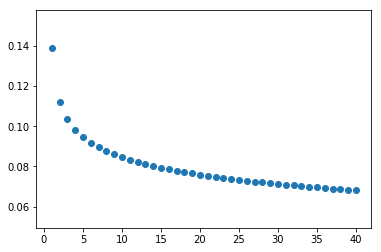

In [0]:
#hazard based on the estimation
hazard_e=(F_t-F_t_m1)/(1-F_t_m1)
print(lmbda,c)
plt.scatter(y1,hazard_e)
plt.show()


### Business Recommendations

Using this model, we can predict what is going to happen in the future. For example, if we have a person who has not relapsed at the end of the second month, can we know the probability for this person to collapse by the end of the third month?

In [0]:
(F_t[2]-F_t[1])/(1-F_t[1])

0.103484657661669

## Two segment Weibull model 

Here, we assume that we have two segments of people, one segment with higher $\lambda$ and one segment with lower $\lambda$. In this case, we will estimate $\lambda_1$, $\lambda_2$, $c$, and $p$. 

In [0]:
y=Patients["time_in_month"].values
censor=Patients["censor"].values
def neg_LL(betas):
  lmbda1=np.exp(betas[0])
  lmbda2=np.exp(betas[1])
  c=np.exp(betas[2])
  p=np.exp(betas[3])/(1+np.exp(betas[3]))
  ind_L1r=(1-np.exp(-(y*lmbda1)**c))-(1-np.exp(-((y-1)*lmbda1)**c))
  ind_L2r=(1-np.exp(-(y*lmbda2)**c))-(1-np.exp(-((y-1)*lmbda2)**c))

  ind_Lr=ind_L1r*p+ind_L2r*(1-p)

  ind_L1c=1-(1-np.exp(-(y*lmbda1)**c))
  ind_L2c=1-(1-np.exp(-(y*lmbda2)**c))
  ind_Lc=ind_L1c*p+ind_L2c*(1-p)

  ind_L=ind_Lr*(1-censor)+ind_Lc*censor

 

  return -np.sum(np.log(ind_L))

guess=-np.random.rand(4)
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

1624.343194917601
[ -1.74115513 -14.53220848   0.15153658   1.5325414 ]


###Model fitting

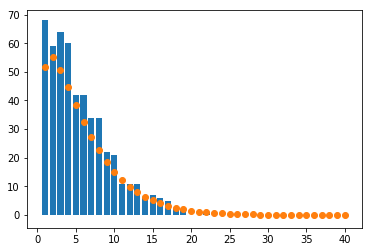

In [0]:
counts=Patients[Patients["censor"]==0].groupby("time_in_month").count()
betas=model1.x
lmbda1=np.exp(betas[0])
lmbda2=np.exp(betas[1])
c=np.exp(betas[2])
p=np.exp(betas[3])/(1+np.exp(betas[3]))
y1=np.arange(1,np.max(y)+1)
ind_L1r=(1-np.exp(-(y1*lmbda1)**c))-(1-np.exp(-((y1-1)*lmbda1)**c))
ind_L2r=(1-np.exp(-(y1*lmbda2)**c))-(1-np.exp(-((y1-1)*lmbda2)**c))

ind_Lr=ind_L1r*p+ind_L2r*(1-p)
prediction=ind_Lr*len(y[censor==0])

plt.bar(counts.index.values, counts.iloc[:,4].values)
plt.scatter(y1,prediction,zorder=2)





###Hazard

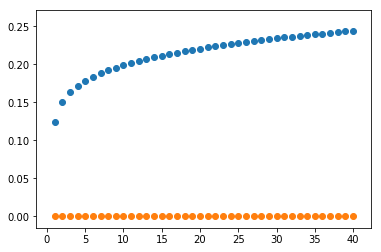

0.1753177691942747 4.883622044870471e-07 1.16362086735394 0.8223778467347836


In [0]:
Ft_1=(1-np.exp(-(y1*lmbda1)**c))
Ftm1_1=(1-np.exp(-((y1-1)*lmbda1)**c))
Ft_2=(1-np.exp(-(y1*lmbda2)**c))
Ftm1_2=(1-np.exp(-((y1-1)*lmbda2)**c))

Hazard_e1=(Ft_1-Ftm1_1)/(1-Ftm1_1)
Hazard_e2=(Ft_2-Ftm1_2)/(1-Ftm1_2)
plt.scatter(y1,Hazard_e1)
plt.scatter(y1,Hazard_e2)
plt.show()

print(lmbda1,lmbda2,c,p)

In [0]:
#the probability for a patient to be belong to segment 1 given that the patient relapsed in 
#period 1, 2, 3, ...
p*ind_L1r/(p*ind_L1r+ (1-p)*ind_L2r)

array([0.99999992, 0.99999991, 0.99999989, 0.99999987, 0.99999984,
       0.99999981, 0.99999976, 0.99999971, 0.99999964, 0.99999955,
       0.99999943, 0.99999929, 0.99999911, 0.99999887, 0.99999857,
       0.99999818, 0.99999769, 0.99999705, 0.99999622, 0.99999516,
       0.99999378, 0.999992  , 0.99998968, 0.99998666, 0.99998274,
       0.99997762, 0.99997093, 0.99996218, 0.99995073, 0.9999357 ,
       0.99991598, 0.99989004, 0.99985589, 0.99981088, 0.99975149,
       0.99967302, 0.99956925, 0.99943186, 0.99924977, 0.99900821])

In [0]:
#N
N=10000
#No risk Segment 
Segment1_N=np.repeat(N*p,len(y1))
#risk Segment
Segment2_N=N*(1-Ftm1_2)*(1-p)

Segment1_N/(Segment1_N+Segment2_N)



array([0.17764531, 0.19773014, 0.22495275, 0.25750628, 0.29509964,
       0.33747234, 0.38417912, 0.43450681, 0.48745697, 0.54178722,
       0.59610554, 0.64900126, 0.69918542, 0.74561032, 0.78754492,
       0.82459677, 0.85668583, 0.88398575, 0.90685052, 0.92574235,
       0.94117033, 0.95364446, 0.96364496, 0.97160463, 0.97790106,
       0.98285567, 0.98673681, 0.98976519, 0.9921201 , 0.99394581,
       0.99535745, 0.99644629, 0.99728431, 0.99792798, 0.99842146,
       0.99879913, 0.99908769, 0.99930783, 0.99947552, 0.99960308])

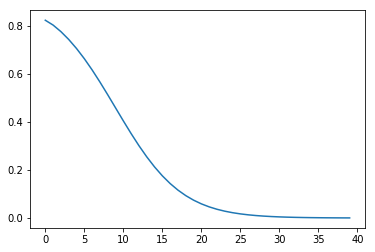

In [0]:
#the probability for a patient to belong to the first segment given 
#that the patient did not relapse before
P_post=p*(1-Ftm1_1)/(p*(1-Ftm1_1)+ (1-p)*(1-Ftm1_2))
P_post
plt.plot(P_post)

In [0]:
np.diff(P_post)/P_post[0:-1]

array([-0.02442335, -0.03393217, -0.04200291, -0.05063319, -0.06011498,
       -0.0705029 , -0.08173156, -0.09364455, -0.10601279, -0.11855759,
       -0.13098006, -0.14299309, -0.15435001, -0.16486466, -0.17442013,
       -0.18296686, -0.1905127 , -0.19710884, -0.2028349 , -0.20778574,
       -0.21206093, -0.21575746, -0.21896508, -0.22176385, -0.22422333,
       -0.22640267, -0.22835145, -0.23011065, -0.2317139 , -0.23318855,
       -0.23455676, -0.23583639, -0.23704181, -0.23818459, -0.23927401,
       -0.24031755, -0.24132122, -0.2422899 , -0.24322755])

###Posterior analysis

In this model, we are able to identify two groups of people. 

* Group 1: with high $\lambda$. This group of people are will on average having higher risk relapsing.
* Group 2: with low $\lambda$. This group of people are will on average having lower risk relapsing.

By observing the $t$, we can update our information of which risk group a patient belongs to. Thus, we will have a better idea of when relapse might happen.

In [0]:
#Consider the following two patients
#Patient who relapsed in month 5.
#Answer: P(Group1)=1, P(Group2)=0


#Patient who is censored and has not relapsed by the end of month 7.
#Do the posterior analysis for these two patients. 
(p*(1-Ftm1_1)/(p*(1-Ftm1_1)+ (1-p)*(1-Ftm1_2)))[7]

0.4345090205022635

## Continuous observed heterogeneity

We can moved on to assume that $\lambda \sim Gamma (\gamma, \alpha)$.

The distribution of $t$ is called Weibull-Gamma distribution and will have the following PDF:

$f(t)=\frac{c\gamma t^c(\frac{\alpha}{\alpha+t^c})^\gamma}{t(\alpha+t^c)}$

$F(t)=1-(\frac{\alpha}{\alpha+t^c})^\gamma$



In [0]:
##y=Patients["time"].values
y=Patients["time_in_month"].values
censor=Patients["censor"].values
def neg_LL(betas):
  alpha=np.exp(betas[0])
  gamma=np.exp(betas[1])
  c=np.exp(betas[2])
  Ft=(1-(alpha/(alpha+y**c))**gamma)
  Ft1=(1-(alpha/(alpha+(y-1)**c))**gamma)
  ind_Lr=Ft-Ft1
  ind_Lc=1-Ft
  ind_L=ind_Lr*(1-censor)+ind_Lc*censor 

  return -np.sum(np.log(ind_L))

guess= -np.random.rand(3)
model1=minimize(neg_LL,guess,method="BFGS")
print(model1.fun)
print(model1.x)

1633.721272199543
[ 1.86109214 -0.34711265  0.34191655]


###Model fitting

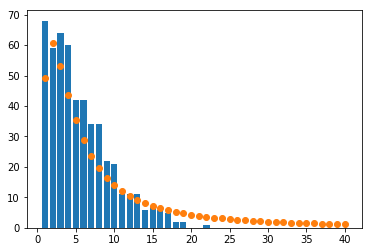

In [0]:
counts=Patients[Patients["censor"]==0].groupby("time_in_month").count()
betas=model1.x
y1=np.arange(1,np.max(y)+1)

alpha=np.exp(betas[0])
gamma=np.exp(betas[1])
c=np.exp(betas[2])
Ft=(1-(alpha/(alpha+y1**c))**gamma)
Ft1=(1-(alpha/(alpha+(y1-1)**c))**gamma)
ind_Lr=Ft-Ft1
prediction= ind_Lr*(len(y[censor==0]))
  

plt.bar(counts.index.values, counts.iloc[:,4].values)
plt.scatter(y1,prediction,zorder=2)





###Hazard

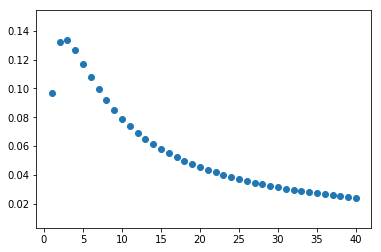

In [0]:
hazard_wg=(Ft-Ft1)/(1-Ft1)
plt.scatter(y1,hazard_wg)

###Posterior Analysis

For Weibull-Gamma, the posterior distribution for a patient is 

$$\lambda|t \sim Gamma(\gamma+1, \alpha+t^c)$$

That is, if we see a patient relapsed in time $t$, then the distribution $\lambda$ for this patient will follow a gamma distribution.

In [0]:
#assume a patient relapsed in month 5

#lmbda|t=5~Gamma(gamma+1,alpha+5**c)
#E(lmbda)=(gamma+1)/(alpha+5**c)

#assume a patient relapsed in month 7

#lmbda|t=7~Gamma(gamma+1,alpha+7**c)
#E(lmbda)=(gamma+1)/(alpha+7**c)

